# Figure 3

This notebook contains the code required to plot Figure 3 of Dawson et al. (2025). 

In [1]:
# datasets/analysis
import numpy as np
import xarray as xr
from glob import glob

# cosima
import cosima_cookbook as cc

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cmocean.cm as cmo

In [2]:
import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44567/status,
Dashboard: /proxy/44567/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42029,Workers: 7
Dashboard: /proxy/44567/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:44343,Total threads: 4
Dashboard: /proxy/40281/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:43255,


In [4]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations
session_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db'
expt_session = cc.database.create_session(session_dir)
ssp585 = '01deg_jra55v13_ryf9091_ssp585'
ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'
ssp245 = '01deg_jra55v13_ryf9091_ssp245'
ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'

## Fig 1A and 1B: SWMT & cross-isobath transport

Define functions to read data. 

In [5]:
def get_SWMT(outpath, expt, time_bounds):

    net_transformation = xr.open_dataset(outpath + f'/SWMT_{expt}_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(outpath + f'/HT_{expt}_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(outpath + f'/ST_{expt}_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation

    return net_transformation, heat_transformation, salt_transformation

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map
    
def antarctic_SWMT_sum(outpath, expt, session, time_bounds):
    #outpath = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT_temp/'
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1) 
    swmt, heat, salt = get_SWMT(outpath, expt, time_bounds)
    
    ## sum over region, convert to Sv
    isopycnal_bin_mid = swmt.isopycnal_bins
    # restrict to Antarctic shelf
    swmt_shelf, shelf_mask = shelf_mask_isobath(swmt)
    heat_shelf, shelf_mask = shelf_mask_isobath(heat)
    salt_shelf, shelf_mask = shelf_mask_isobath(salt)
    area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
    swmt_shelf_sum = (swmt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).compute()
    heat_shelf_sum = (heat_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).compute()
    salt_shelf_sum = (salt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).compute()

    return swmt_shelf_sum, heat_shelf_sum, salt_shelf_sum, isopycnal_bin_mid


def read_cross_shelf_transport(path, first_file, time_array):
    '''
    path: array of directory paths to monthly files containing cross-shelf volume transport data
    first_file: full path to first month (2150_01) of cross-shelf volume transport data
    '''
    vol_transp = xr.open_dataset(first_file)
    
    for i in range(1, len(path)):
        vol_transp = xr.concat([vol_transp, xr.open_dataset(path[i])], dim = 'time')

    vol_transp['time'] = time_array['time'].values
    vol_transp_total = (vol_transp['vol_trans_across_contour_binned']*vol_transp['ndays']).sum('time')/np.sum(vol_transp['ndays'])
    
    return vol_transp, vol_transp_total

def calc_circumAntarctic_transport_across_isopycnals(vol_transport, ti , tf):

    # extract volume transport variable and restrict to time range of interest
    vol_transport = vol_transport.sel(time=slice(ti, tf))['vol_trans_across_contour_binned']
    # sum along contour
    net_offshore_transport = vol_transport.sum('contour_index')
    # cumsum transport from the bottom (upwards from densest isopycnals) and convert to Sverdrups
    cumsum_offshore_transport = net_offshore_transport[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
    # take the mean in time 
    mean_transport_Sv = cumsum_offshore_transport.mean('time')
    std_transport_Sv = cumsum_offshore_transport.std('time')

    return mean_transport_Sv, std_transport_Sv
    

Read in data. 

In [7]:
%%time
### SWMT ### -------------------------
outpath = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT/sigma0/'
time_bounds = '2160_1-2164_12'

### Offshore Transport ### -----------
# set up time array (transports only available for Control during the first 10 years)
ti = '2150-01-01'
tf = '2160-06-30'
slev_ctrl = cc.querying.getvar(control, 'sea_level', master_session, start_time=ti, end_time=tf).sel(time=slice(ti, tf), yt_ocean=slice(None, -58))

# offshore transport in control
path_ctrl = np.sort(glob('/g/data/g40/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/*'))
file_ctrl = '/g/data/g40/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc'
time_array = slev_ctrl
vol_transp_ctrl, vol_transp_ctrl_total = read_cross_shelf_transport(path_ctrl, file_ctrl, time_array)
vol_transport_Sv_ctrl, std_ctrl = calc_circumAntarctic_transport_across_isopycnals(vol_transp_ctrl, ti , tf)

# offshore transports in experiment
# set up time array
ti = '2150-01-01'
tf = '2164-12-31'
slev_expts = cc.querying.getvar(ssp245, 'sea_level', expt_session, start_time=ti, end_time=tf).sel(time=slice(ti, tf), yt_ocean=slice(None, -58))
time_array = slev_expts
# SSP245
path_ssp245 = np.sort(glob('/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp245/*'))
file_ssp245 = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp245/vol_trans_across_contour_2150_01_sigma1.nc'
vol_transp_ssp245, vol_transp_ssp245_total = read_cross_shelf_transport(path_ssp245, file_ssp245, time_array)
# SSP245 MW
path_ssp245mw = np.sort(glob('/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp245_mw/*'))
file_ssp245mw = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp245_mw/vol_trans_across_contour_2150_01_sigma1.nc'
vol_transp_ssp245mw, vol_transp_ssp245mw_total = read_cross_shelf_transport(path_ssp245mw, file_ssp245mw, time_array)
# SSP585
path_ssp585 = np.sort(glob('/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp585/*'))
file_ssp585 = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp585/vol_trans_across_contour_2150_01_sigma1.nc'
vol_transp_ssp585, vol_transp_ssp585_total = read_cross_shelf_transport(path_ssp585, file_ssp585, time_array)
# SSP585 MW
path_ssp585mw = np.sort(glob('/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp585_mw/*'))
file_ssp585mw = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/antarctic_cross_slope/01deg_jra55v13_ryf9091_ssp585_mw/vol_trans_across_contour_2150_01_sigma1.nc'
vol_transp_ssp585mw, vol_transp_ssp585mw_total = read_cross_shelf_transport(path_ssp585mw, file_ssp585mw, time_array)

CPU times: user 2min 1s, sys: 2min 25s, total: 4min 26s
Wall time: 4min 27s


Calculate mean offshore transport across different isopycnals. 

In [8]:
# restrict to last 5 years of experiments
ti = '2160-01-01'
tf = '2164-12-31'
vol_transport_Sv_ssp245, std_ssp245 = calc_circumAntarctic_transport_across_isopycnals(vol_transp_ssp245, ti , tf)
vol_transport_Sv_ssp245mw, std_ssp245mw = calc_circumAntarctic_transport_across_isopycnals(vol_transp_ssp245mw, ti , tf)
vol_transport_Sv_ssp585, std_ssp585 = calc_circumAntarctic_transport_across_isopycnals(vol_transp_ssp585, ti , tf)
vol_transport_Sv_ssp585mw, std_ssp585mw = calc_circumAntarctic_transport_across_isopycnals(vol_transp_ssp585mw, ti , tf)

Standard deviation (annual mean)

In [9]:
annualstd_vol_transp_ctrl = vol_transp_ctrl.sel(time=slice('2160-01-01','2164-12-31'))['vol_trans_across_contour_binned'].sum('contour_index')#
annualstd_vol_transp_ctrl = annualstd_vol_transp_ctrl[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
annualstd_vol_transp_ctrl = annualstd_vol_transp_ctrl.groupby('time.year').mean('time').std('year')

annualstd_vol_transp_ssp245 = vol_transp_ssp245.sel(time=slice('2160-01-01','2164-12-31'))['vol_trans_across_contour_binned'].sum('contour_index')#
annualstd_vol_transp_ssp245 = annualstd_vol_transp_ssp245[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
annualstd_vol_transp_ssp245 = annualstd_vol_transp_ssp245.groupby('time.year').mean('time').std('year')

annualstd_vol_transp_ssp245mw = vol_transp_ssp245mw.sel(time=slice('2160-01-01','2164-12-31'))['vol_trans_across_contour_binned'].sum('contour_index')#
annualstd_vol_transp_ssp245mw = annualstd_vol_transp_ssp245mw[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
annualstd_vol_transp_ssp245mw = annualstd_vol_transp_ssp245mw.groupby('time.year').mean('time').std('year')

annualstd_vol_transp_ssp585 = vol_transp_ssp585.sel(time=slice('2160-01-01','2164-12-31'))['vol_trans_across_contour_binned'].sum('contour_index')#
annualstd_vol_transp_ssp585 = annualstd_vol_transp_ssp585[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
annualstd_vol_transp_ssp585 = annualstd_vol_transp_ssp585.groupby('time.year').mean('time').std('year')

annualstd_vol_transp_ssp585mw = vol_transp_ssp585mw.sel(time=slice('2160-01-01','2164-12-31'))['vol_trans_across_contour_binned'].sum('contour_index')#
annualstd_vol_transp_ssp585mw = annualstd_vol_transp_ssp585mw[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
annualstd_vol_transp_ssp585mw = annualstd_vol_transp_ssp585mw.groupby('time.year').mean('time').std('year')

Plot figure. 

In [10]:
colours = ['k', '#92c5de', '#0571b0', '#fdae61', '#ca0020', ]
expt_labels = ['CONTROL', 'SSP245', 'SSP245-MW', 'SSP585', 'SSP585-MW']
expts = [control, ssp245, ssp245mw, ssp585, ssp585mw]
peak_swmt_arr = np.zeros(5)
peak_rho_arr = np.zeros(5)
half_swmt_arr = np.zeros(5)
threequarter_swmt_arr = np.zeros(5)
time_bounds = '2160_1-2164_12'
outpath = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT/sigma0/'
outpath_yrly = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT/sigma0/yearly/'

2160 2160_1-2160_12
2161 2161_1-2161_12
2162 2162_1-2162_12
2163 2163_1-2163_12
2164 2164_1-2164_12
2160 2160_1-2160_12
2161 2161_1-2161_12
2162 2162_1-2162_12
2163 2163_1-2163_12
2164 2164_1-2164_12
2160 2160_1-2160_12
2161 2161_1-2161_12
2162 2162_1-2162_12
2163 2163_1-2163_12
2164 2164_1-2164_12
2160 2160_1-2160_12
2161 2161_1-2161_12
2162 2162_1-2162_12
2163 2163_1-2163_12
2164 2164_1-2164_12
2160 2160_1-2160_12
2161 2161_1-2161_12
2162 2162_1-2162_12
2163 2163_1-2163_12
2164 2164_1-2164_12


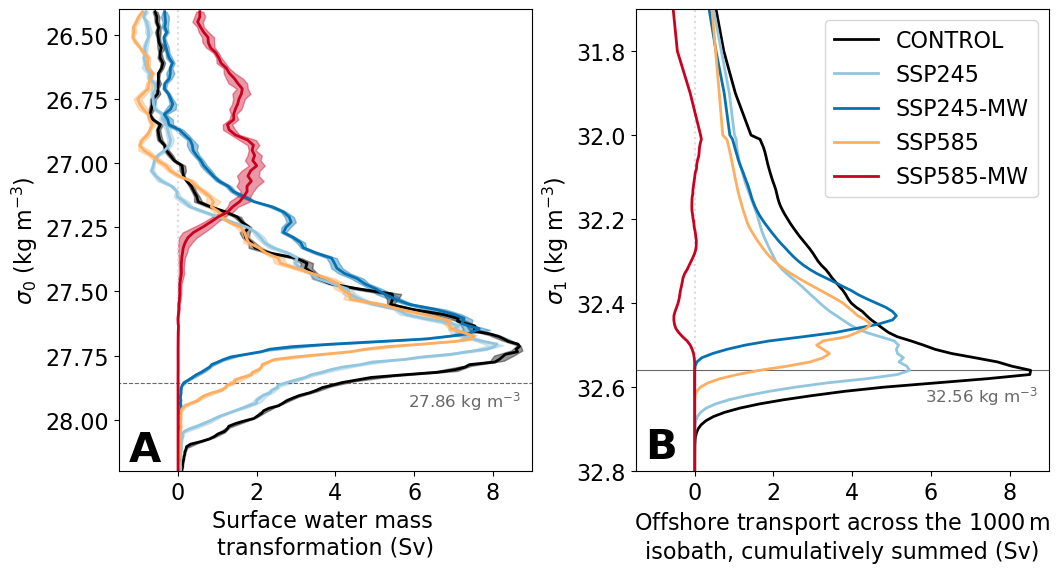

In [11]:
# create figure
plt.rcParams['font.size'] = 16
figure_1AB, axes = plt.subplots(ncols = 2, figsize = (12, 6))
plt.subplots_adjust(wspace=0.25)

# Set labels and text
axes[0].set_xlabel('Surface water mass \ntransformation (Sv)')
axes[1].set_xlabel(f'Offshore transport across the 1000$\,$m\nisobath, cumulatively summed (Sv)')
axes[0].set_ylabel(r'$\sigma_{0}$ (kg m$^{-3}$)')
axes[1].set_ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)')
axes[0].text(-1.25, 28.16, 'A',  c='k', fontsize=30, fontweight='bold',)
axes[1].text(-1.25, 32.77, 'B',  c='k', fontsize=30, fontweight='bold',)

# plot zero lines
axes[0].plot([0,0],[26, 29], c='gainsboro', ls=':')
axes[1].plot([0,0],[31, 33], c='gainsboro', ls=':')

# plot SWMT
expts = [control, ssp245, ssp245mw, ssp585, ssp585mw]
for i, expt in enumerate(expts): 
    yr = 2160
    count = 0
    
    if expt == control:
        swmt, heat, salt, isopycnal_bin_mid = antarctic_SWMT_sum(outpath, expt, master_session, time_bounds)
        
        # save values
        peak, peak_idx = swmt.max(), swmt.argmax().values
        peak_swmt_arr[i] = peak
        peak_rho_arr[i] = swmt.isopycnal_bins[peak_idx]
        half_peak_idx = np.abs((swmt - peak*0.5)).argmin().values
        half_peak_rho = swmt.isopycnal_bins[half_peak_idx]
        half_swmt_arr[i] = swmt[half_peak_idx].values
        threequarter_idx = np.abs((swmt - peak*0.25)).argmin().values
        threequarter_swmt_arr[i] = swmt[threequarter_idx].values
        
        # plot line for half of swmt peak in control
        axes[0].plot([-2,10],[half_peak_rho, half_peak_rho], c='dimgrey', ls='--', lw=0.8)
        axes[0].text(0.7, 0.14, f'{np.round(half_peak_rho.values, decimals=2)}'+r' kg m$^{-3}$', 
                     fontsize=12, c='dimgrey',transform=axes[0].transAxes)
        while yr <= 2164:
            time_bounds_yrly = f'{yr}_1-{yr}_12'
            print(yr, time_bounds_yrly)
            if yr == 2160:
                swmt_yrly, heat, salt, isopycnal_bin_mid = antarctic_SWMT_sum(outpath_yrly, expt, master_session, time_bounds_yrly)
                swmt_yrly = swmt_yrly.expand_dims(dim={"year": np.arange(5)}, axis=0).copy()
            else:
                swmt_tmp, heat, salt, isopycnal_bin_mid = antarctic_SWMT_sum(outpath_yrly, expt, master_session, time_bounds_yrly)
                swmt_yrly[count, :] = swmt_tmp.values
            yr+=1
            count+=1
        
    else:
        swmt, heat, salt, isopycnal_bin_mid = antarctic_SWMT_sum(outpath, expt, expt_session, time_bounds)

        # save values
        peak, peak_idx = swmt.max(), swmt.argmax().values
        peak_swmt_arr[i] = peak
        peak_rho_arr[i] = swmt.isopycnal_bins[peak_idx]
        half_swmt_arr[i] = swmt[half_peak_idx].values
        threequarter_swmt_arr[i] = swmt[threequarter_idx].values
        while yr <= 2164:
            time_bounds_yrly = f'{yr}_1-{yr}_12'
            print(yr, time_bounds_yrly)
            if yr == 2160:
                swmt_yrly, heat, salt, isopycnal_bin_mid = antarctic_SWMT_sum(outpath_yrly, expt, expt_session, time_bounds_yrly)
                swmt_yrly = swmt_yrly.expand_dims(dim={"year": np.arange(5)}, axis=0).copy()
            else:
                swmt_tmp, heat, salt, isopycnal_bin_mid = antarctic_SWMT_sum(outpath_yrly, expt, expt_session, time_bounds_yrly)
                swmt_yrly[count, :] = swmt_tmp.values
            yr+=1
            count+=1
        
    axes[0].plot(swmt, swmt.isopycnal_bins, c=colours[i], zorder=2, lw=2, label=expt_labels[i])
    axes[0].fill_betweenx(swmt_yrly.isopycnal_bins, swmt_yrly.mean(dim='year')-swmt_yrly.std(dim='year'), 
                          swmt_yrly.mean(dim='year')+swmt_yrly.std(dim='year'), color=colours[i], alpha=0.4)

# plot offshore transport
isopycnal_bins = vol_transport_Sv_ctrl.isopycnal_bins
axes[1].plot(vol_transport_Sv_ctrl, isopycnal_bins, color=colours[0], lw=2, label=f'{expt_labels[0]}', zorder=2)
axes[1].plot(vol_transport_Sv_ssp245, isopycnal_bins, color=colours[1], lw=2, label=f'{expt_labels[1]}', zorder=2)
axes[1].plot(vol_transport_Sv_ssp245mw, isopycnal_bins, color=colours[2], lw=2, label=f'{expt_labels[2]}', zorder=2)
axes[1].plot(vol_transport_Sv_ssp585,isopycnal_bins, color=colours[3], lw=2, label=f'{expt_labels[3]}', zorder=2)
axes[1].plot(vol_transport_Sv_ssp585mw, isopycnal_bins, color=colours[4], lw=2, label=f'{expt_labels[4]}', zorder=2)

# plot line for peak transport in control
peak_idx = vol_transport_Sv_ctrl.argmax()
peak_rho = vol_transport_Sv_ctrl.isopycnal_bins[peak_idx.values]
axes[1].plot([-2,10],[peak_rho, peak_rho], c='dimgrey', ls='-', lw=0.8, zorder=1)
axes[1].text(0.7, 0.15, f'{np.round(peak_rho.values, decimals=2)}'+r' kg m$^{-3}$', 
             fontsize=12, c='dimgrey',transform=axes[1].transAxes)

# set axis limits
axes[0].set_ylim([28.2, 26.4])
axes[0].set_xlim([-1.5,9])
axes[1].set_ylim((32.8,31.7))
axes[1].set_xlim([-1.5,9])

# plt legend
axes[1].legend(loc='upper right')

# save to file
save_flag = 0
figfile = '../figs/Fig03_AB_annual_std.jpg'
if save_flag == 1:
    figure_1AB.savefig(figfile, bbox_inches='tight', dpi=300)

plt.show()

In [15]:
print(expts)
print("Peak SWMT", np.round(peak_swmt_arr, decimals=2))
print("Peak SWMT density", np.round(peak_rho_arr, decimals=2))
print("DSW Formation", np.round(half_swmt_arr, decimals=2))
print("DSW Formation (% of control)", np.round(half_swmt_arr/half_swmt_arr[0]*100, decimals=2))
print("DSW Formation (% reduction from control)", np.round((half_swmt_arr[0] - half_swmt_arr)/half_swmt_arr[0]*100, decimals=2))

['01deg_jra55v13_ryf9091', '01deg_jra55v13_ryf9091_ssp245', '01deg_jra55v13_ryf9091_ssp245_mw', '01deg_jra55v13_ryf9091_ssp585', '01deg_jra55v13_ryf9091_ssp585_mw']
Peak SWMT [8.67 8.1  7.65 7.52 2.  ]
Peak SWMT density [27.72 27.71 27.65 27.68 27.01]
DSW Formation [4.17 2.77 0.15 1.45 0.  ]
DSW Formation (% of control) [1.000e+02 6.642e+01 3.650e+00 3.474e+01 3.000e-02]
DSW Formation (% reduction from control) [ 0.   33.58 96.35 65.26 99.97]


In [17]:
# print peak transport and sigma_1 values
peak_transport_arr = np.zeros(5)
peak_transport_arr[0] = vol_transport_Sv_ctrl.max().values
peak_transport_arr[1] = vol_transport_Sv_ssp245.max().values
peak_transport_arr[2] = vol_transport_Sv_ssp245mw.max().values
peak_transport_arr[3] = vol_transport_Sv_ssp585.max().values
peak_transport_arr[4] = vol_transport_Sv_ssp585mw.max().values
print("Peak offshore transport", np.round(peak_transport_arr, decimals=2))

peak_transport_rho = np.zeros(5)
peak_transport_rho[0] = vol_transport_Sv_ctrl.isopycnal_bins[peak_idx.values]
peak_idx = vol_transport_Sv_ssp245.argmax()
peak_transport_rho[1] = vol_transport_Sv_ssp245.isopycnal_bins[peak_idx.values]
peak_idx = vol_transport_Sv_ssp245mw.argmax()
peak_transport_rho[2] = vol_transport_Sv_ssp245mw.isopycnal_bins[peak_idx.values]
peak_idx = vol_transport_Sv_ssp585.argmax()
peak_transport_rho[3] = vol_transport_Sv_ssp585.isopycnal_bins[peak_idx.values]
peak_idx = vol_transport_Sv_ssp585mw.argmax()
peak_transport_rho[4] = vol_transport_Sv_ssp585mw.isopycnal_bins[peak_idx.values]
print("Peak offshore transport density", np.round(peak_transport_rho, decimals=2))

Peak offshore transport [8.53 5.46 5.12 4.47 0.22]
Peak offshore transport density [32.56 32.56 32.43 32.45  1.  ]


## Figure 1C and 1D

Fig 1C contains a plot of SWMT from the control in each of the four DSW regions and Fig 1D contains a bar chart showing changes to DSW export in each of the four regions across the experiments. 

Read in data for plotting. 

In [23]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90
fontsize=16

def colorbar_vert(fig, cb, axes, label, extend):
    fontsize=16
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation='vertical', extend=extend)
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)
    return cbar

# for potting 1000 m contour
expt = '01deg_jra55v13_ryf9091'
lat_range = slice(-90,-59)

# ### Open contour data 
isobath_depth = 1000
outfile = '/g/data/ik11/grids/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']
yt_ocean = cc.querying.getvar(expt,'yt_ocean',master_session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',master_session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',master_session,n=1)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',master_session,n=1)

# Convert contour masks to data arrays, so we can multiply them later.
mask_x_transport = xr.DataArray(mask_x_transport, coords=[('y_ocean', yt_ocean.data), ('x_ocean', xu_ocean.data)])
mask_y_transport = xr.DataArray(mask_y_transport, coords=[('y_ocean', yu_ocean.data), ('x_ocean', xt_ocean.data)])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords=[('y_ocean', yt_ocean.data), ('x_ocean', xu_ocean.data)])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords=[('y_ocean', yu_ocean.data), ('x_ocean', xt_ocean.data)])

# Stack contour data into 1D
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean

# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

Define function to mask DSW regions. 

In [25]:
def mask_from_polygon(lon, lat, xt_ocean, yt_ocean):
    polygon = [(lon[0], lat[0])]
    for l in range(1, len(lon)):
        polygon += [(lon[l], lat[l])]
    poly_path = mpath.Path(polygon)

    x, y = xr.broadcast(xt_ocean, yt_ocean)
    coors = np.hstack((x.values.reshape(-1, 1), y.values.reshape(-1, 1)))

    mask = poly_path.contains_points(coors)
    mask = mask.reshape(xt_ocean.size, yt_ocean.size).transpose()
    mask = xr.DataArray(
    mask, dims=['yt_ocean', 'xt_ocean'],
    coords={'xt_ocean': xt_ocean, 'yt_ocean': yt_ocean})
    return mask

def masks():
    # load swmt from control
    swmt_control = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT/sigma0/SWMT_01deg_jra55v13_ryf9091_2160_1-2164_12.nc')
    
    # topography data:
    ht = cc.querying.getvar(control,'ht' , master_session,n=1)
    land_mask = np.squeeze(ht.values)*0
    land_mask[np.isnan(land_mask)] = 1
    land_mask = np.where(land_mask==1,land_mask,np.nan)
    land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
    
    # modify southern mosst latitude 
    land_mask_lat = ht.yt_ocean.values

    # Southern Ocean bathymetry (needs some manual edits)
    ht_so = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=slice(None,-59))
    ht_so = ht_so.where(ht_so<=1000., -999.)
    ht_so = ht_so.where(ht_so != -999, np.nan)
    ht_so = ht_so.where(np.isnan(ht_so), 1.)
    ht_so[138:142, 836:870] = 1.
    ht_so[142:152, 841:870] = 1.
    ht_so[331:350, 647:660] = 1.
    ht_so[310:350, 669:680] = 1.
    ht_so[80:120, 2380:2452] = 1.
    ht_so[71:80, 2396:2440] = 1.
    ht_so[70:72, 2411:2440] = 1.
    ht_so[69, 2416:2440] = 1.
    ht_so[322:330, 3420:3500] = 1.
    ht_so[326:340, 3400:3430] = 1.
    ht_so[335:345, 3373:3394] = 1.
    
    # set up empty masks:
    Ross_mask = swmt_control.surface_water_mass_transformation[0,...]*0+1
    Ross_mask = Ross_mask.fillna(1)
    Adelie_mask = Ross_mask.copy()
    Weddell_mask = Ross_mask.copy()
    Prydz_mask = Ross_mask.copy()
    yt_ocean = Ross_mask.yt_ocean
    xt_ocean = Ross_mask.xt_ocean
    
    # Define regional masks:
    swmt, heat, salt = get_SWMT(outpath, control, time_bounds)
    yt_ocean = swmt.yt_ocean#.values
    xt_ocean = swmt.xt_ocean#.values
    lon = [-175, -200, -196, -189, -175]
    lat = [-78.5, -78.5, -71.9, -71.9, -78.5]
    Ross_mask = mask_from_polygon(lon, lat, xt_ocean, yt_ocean)
    Ross_mask = Ross_mask*ht_so
    Ross_mask = Ross_mask.where(Ross_mask == 1., np.nan)
    Prydz_mask = Prydz_mask.where(yt_ocean<-66).where(yt_ocean>-69).where(xt_ocean>57.5).where(xt_ocean<73)
    Prydz_mask = Prydz_mask*ht_so
    Adelie_mask = Adelie_mask.where(yt_ocean<-64).where(yt_ocean>-69).where(xt_ocean>136-360).where(xt_ocean<148-360)
    Adelie_mask = Adelie_mask*ht_so
    
    # two areas to consider for this one:
    Weddell_maskW = Weddell_mask.where(yt_ocean<-71).where(yt_ocean>-79).where(xt_ocean>297-360).where(xt_ocean<315-360)
    Weddell_maskE = Weddell_mask.where(yt_ocean<-73).where(yt_ocean>-79).where(xt_ocean>315-360).where(xt_ocean<328-360)
    Weddell_mask = Weddell_maskE.fillna(0) + Weddell_maskW.fillna(0)
    Weddell_mask = Weddell_mask.where(Weddell_mask == 1)
    Weddell_mask = Weddell_mask*ht_so
    
    # combine all masks:
    DSW_mask = Weddell_mask.fillna(0) + Prydz_mask.fillna(0)*2 + Adelie_mask.fillna(0)*3 + Ross_mask.fillna(0)*4

    return DSW_mask.compute()

fontsize=16

Create DSW mask. 

In [26]:
DSW_mask = masks()

Define functions required for this section. 

In [27]:
def regional_SWMT_sum(outpath, expt, session, time_bounds, DSW_mask, idx):
    outpath = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT/sigma0/'
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1) 
    swmt, heat, salt = get_SWMT(outpath, expt, time_bounds) 
    
    ## sum over region, convert to Sv
    isopycnal_bin_mid = swmt.isopycnal_bins
    # restrict to Antarctic shelf
    swmt_shelf, shelf_mask = shelf_mask_isobath(swmt) 
    heat_shelf, shelf_mask = shelf_mask_isobath(heat)
    salt_shelf, shelf_mask = shelf_mask_isobath(salt)
    area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
    
    # restrict to region of interest
    mask_tmp = DSW_mask.where(DSW_mask == idx)
    mask_tmp = mask_tmp.where(np.isnan(mask_tmp), 1.)
    swmt_shelf_sum = (swmt_shelf * area_t_shelf * mask_tmp / 1e6).sum(['xt_ocean', 'yt_ocean']).compute()
    heat_shelf_sum = (heat_shelf * area_t_shelf * mask_tmp / 1e6).sum(['xt_ocean', 'yt_ocean']).compute()
    salt_shelf_sum = (salt_shelf * area_t_shelf * mask_tmp / 1e6).sum(['xt_ocean', 'yt_ocean']).compute()

    return swmt_shelf_sum, heat_shelf_sum, salt_shelf_sum, isopycnal_bin_mid

def regional_SWMT(outpath, expt, session, time_bounds, DSW_mask, idx):
    outpath = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT/sigma0/'
    swmt, heat, salt = get_SWMT(outpath, expt, time_bounds) 
    
    ## sum over region, convert to Sv
    isopycnal_bin_mid = swmt.isopycnal_bins
    # restrict to Antarctic shelf
    swmt_shelf, shelf_mask = shelf_mask_isobath(swmt) 
    heat_shelf, shelf_mask = shelf_mask_isobath(heat)
    salt_shelf, shelf_mask = shelf_mask_isobath(salt)
    
    # restrict to region of interest
    mask_tmp = DSW_mask.where(DSW_mask == idx)
    mask_tmp = mask_tmp.where(np.isnan(mask_tmp), 1.)
    swmt_mask = (swmt_shelf * mask_tmp).compute()
    heat_mask = (heat_shelf * mask_tmp).compute()
    salt_mask = (salt_shelf * mask_tmp).compute()

    return swmt_mask, heat_mask, salt_mask, isopycnal_bin_mid

def calc_regional_transport_across_isopycnals(vol_transport, ti , tf):

    # extract volume transport variable and restrict to time range of interest
    vol_transport = vol_transport.sel(time=slice(ti, tf))
    
    # sum along contour
    net_offshore_transport = vol_transport.sum('contour_index')
    
    # cumsum transport from the bottom (upwards from densest isopycnals) and convert to Sverdrups
    cumsum_offshore_transport = net_offshore_transport[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6
    
    # take the mean in time 
    mean_transport_Sv = cumsum_offshore_transport.mean('time')
    std_transport_Sv = cumsum_offshore_transport.std('time')

    return mean_transport_Sv, std_transport_Sv

Calculate SWMT thresholds: Defined as the value at half of control peak density, calculated seperately for each DSW region.  

In [28]:
dsw_regions = ['Weddell', 'Prydz', 'Adélie', 'Ross']
rho_half_peak = np.zeros(len(dsw_regions))

for i, region in enumerate(dsw_regions):
    swmt, heat, salt, isopycnal_bin_mid = regional_SWMT_sum(outpath, control, master_session, time_bounds, DSW_mask, i+1)
    peak_idx_ctrl = np.where(swmt == swmt.max())[0]
    peak_rho_ctrl = isopycnal_bin_mid[peak_idx_ctrl].values
    arr = np.abs(swmt[peak_idx_ctrl[0]:] - swmt.max()*0.5)
    half_idx = np.where(arr == arr.min())[0]
    rho_half_peak[i] = swmt.isel(isopycnal_bins = peak_idx_ctrl[0]+half_idx[0]).isopycnal_bins.values

print(dsw_regions)
print(rho_half_peak)

['Weddell', 'Prydz', 'Adélie', 'Ross']
[27.825 27.815 27.865 28.025]


Calculate DSW export thresholds: Defined as the cumulative sum up to the control peak of export across 1000 m isobath, calculated seperately for each DSW region. 

In [29]:
ti = '2150-01-01'
tf = '2160-06-30'

DSW_region_bounds = {'name': ['Weddell', 'Prydz', 'Adélie', 'Ross'],
                     'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
                     'lon_W': [-60, 45, -240, -205],
                     'lon_E': [-30, 75, -210, -175],
                    }
dsw_export_threshold = xr.DataArray(np.zeros(4), 
                                    coords={'dsw_region': DSW_region_bounds['name']}, 
                                    dims=['dsw_region'])

expt_dim_labels = ['control','ssp245','ssp245mw','ssp585','ssp585mw']
dsw_export = xr.DataArray(np.zeros((5, 4)), 
                          coords={'experiment': expt_dim_labels, 'dsw_region': DSW_region_bounds['name']}, 
                          dims=['experiment', 'dsw_region'])


for i, region in enumerate(DSW_region_bounds['name']):
    print(region, DSW_region_bounds['lon_W'][i], DSW_region_bounds['lon_E'][i])
    idx_W = np.where(lon_along_contour >= DSW_region_bounds['lon_W'][i])[0][0]
    idx_E = np.where(lon_along_contour <= DSW_region_bounds['lon_E'][i])[0][-1]

    # read in volume transport (cumulatively summed) for each experiment in region of interest
    ti = '2150-01-01'
    tf = '2160-06-30'
    vol_transport_Sv_ctrl, std_ctrl = calc_regional_transport_across_isopycnals(vol_transp_ctrl.vol_trans_across_contour_binned[:,:,idx_W:idx_E+1], ti , tf)
    ti = '2160-01-01'
    tf = '2164-12-31'
    vol_transport_Sv_ssp245, std_ssp245 = calc_regional_transport_across_isopycnals(vol_transp_ssp245.vol_trans_across_contour_binned[:,:,idx_W:idx_E+1], ti , tf)
    vol_transport_Sv_ssp245mw, std_ssp245mw = calc_regional_transport_across_isopycnals(vol_transp_ssp245mw.vol_trans_across_contour_binned[:,:,idx_W:idx_E+1], ti , tf)
    vol_transport_Sv_ssp585, std_ssp585 = calc_regional_transport_across_isopycnals(vol_transp_ssp585.vol_trans_across_contour_binned[:,:,idx_W:idx_E+1], ti , tf)
    vol_transport_Sv_ssp585mw, std_ssp585mw = calc_regional_transport_across_isopycnals(vol_transp_ssp585mw.vol_trans_across_contour_binned[:,:,idx_W:idx_E+1], ti , tf)
    
    peak_idx_ctrl = vol_transport_Sv_ctrl.argmax()
    peak_rho_ctrl = vol_transport_Sv_ctrl.isopycnal_bins[peak_idx_ctrl]
    dsw_export_threshold[i] = peak_rho_ctrl.values

    dsw_export[0,i] = vol_transport_Sv_ctrl.sel(isopycnal_bins = dsw_export_threshold[i])
    dsw_export[1,i] = vol_transport_Sv_ssp245.sel(isopycnal_bins = dsw_export_threshold[i])
    dsw_export[2,i] = vol_transport_Sv_ssp245mw.sel(isopycnal_bins = dsw_export_threshold[i])
    dsw_export[3,i] = vol_transport_Sv_ssp585.sel(isopycnal_bins = dsw_export_threshold[i])
    dsw_export[4,i] = vol_transport_Sv_ssp585mw.sel(isopycnal_bins = dsw_export_threshold[i])

print(dsw_export_threshold)
print(dsw_export.values)

Weddell -60 -30
Prydz 45 75
Adélie -240 -210
Ross -205 -175
<xarray.DataArray (dsw_region: 4)>
array([32.53, 32.53, 32.58, 32.57])
Coordinates:
  * dsw_region  (dsw_region) <U7 'Weddell' 'Prydz' 'Adélie' 'Ross'
[[ 1.46872624e+00  2.26913903e+00  1.95783757e+00  4.53629577e+00]
 [ 4.96729026e-01  9.22769030e-01  1.03682275e+00  3.48681772e+00]
 [ 1.00486606e-03 -9.93536301e-05  0.00000000e+00  4.91320993e-05]
 [-1.48269707e-03 -6.63223725e-03  5.82659537e-04  1.08044312e+00]
 [-1.14712841e-02 -6.76624526e-06  0.00000000e+00  0.00000000e+00]]


Plot figure. 

In [30]:
diags = dsw_export.dsw_region.values
expt_vals = {'CONTROL': (dsw_export[0,0], dsw_export[0,1], dsw_export[0,2], dsw_export[0,3]),
             'SSP245':  (dsw_export[1,0], dsw_export[1,1], dsw_export[1,2], dsw_export[1,3]),
             'SSP245-MW': (dsw_export[2,0], dsw_export[2,1], dsw_export[2,2], dsw_export[2,3]),
             'SSP585':    (dsw_export[3,0], dsw_export[3,1], dsw_export[3,2], dsw_export[3,3]),
             'SSP585-MW': (dsw_export[4,0], dsw_export[4,1], dsw_export[4,2], dsw_export[4,3]),
            }

In [31]:
def plot_text(p1, p2, ax, ang_d, txt):
    # Locations to plot text
    l1 = np.array((p1[0], p1[1]))
    l2 = np.array((p2[0], p2[1]))

    # Plot text
    th1 = ax.text(l1[0], l1[1], txt, fontsize=12, \
                  transform=ccrs.PlateCarree(), \
                  ha="center", color='grey',\
                  rotation=ang_d, rotation_mode='anchor')
    return th1

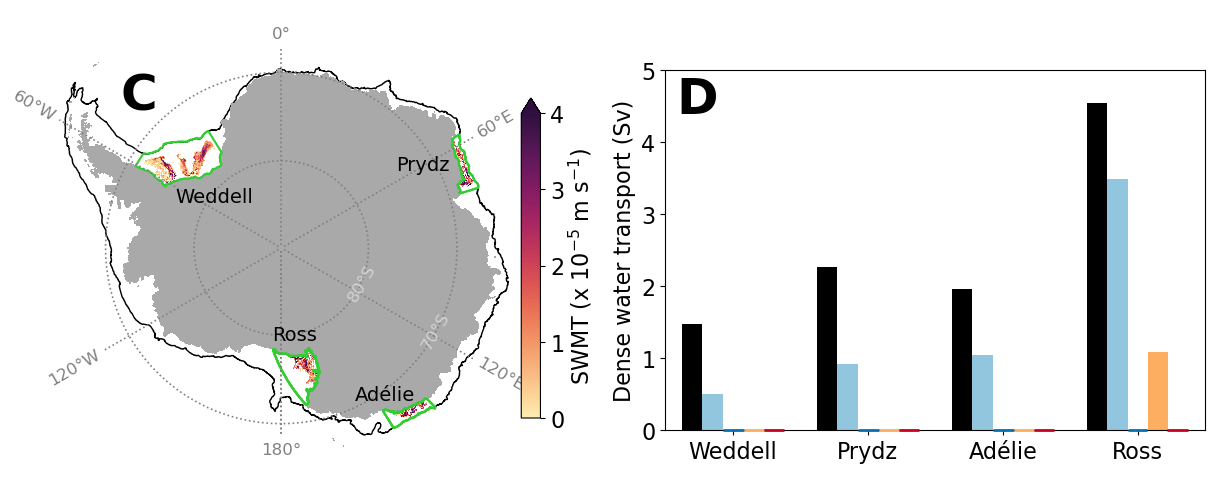

In [32]:
plt.rcParams['font.size'] = 16
colours = ['k', '#92c5de', '#0571b0', '#fdae61', '#ca0020']

# start figure
figure_1CD = plt.figure(1,figsize = (12, 4))

### PANEL C: SWMT map --------------------------------------
ax1 = figure_1CD.add_axes([-.35,-0.05,1.1,1.15], projection = ccrs.SouthPolarStereo())
ax1.plot(lon_along_contour,lat_along_contour,c='k',lw=1,transform = ccrs.PlateCarree())
ax1.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax1.set_extent([-180, 180, -90, -64], ccrs.PlateCarree())
ax1.axis("off")

# contour DSW region masks
ax1.contour(DSW_mask.xt_ocean, DSW_mask.yt_ocean, DSW_mask, 
           levels = [0,1,2,3,4], colors='limegreen', transform = ccrs.PlateCarree())

# shade SWMT in each DSW region at each threshold
for i, region in enumerate(dsw_regions):
    swmt, heat, salt, isopycnal_bin_mid = regional_SWMT(outpath, control, master_session, time_bounds, DSW_mask, i+1)
    cb = ax1.pcolormesh(swmt.xt_ocean, swmt.yt_ocean, 
                  swmt.sel(isopycnal_bins = rho_half_peak[i])*1e5, 
                  cmap=cmo.matter, vmin=0, vmax=4, transform = ccrs.PlateCarree())

# Draw gridlines
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1.2, xlocs=range(-180, 181, 60), ylocs=[-80,-70], 
             color='grey', alpha=1, linestyle=':', rotate_labels=False )

# plot latitude labels
ax1.text(123, -79, '80\u00b0S', ha='center', color='lightgrey', fontsize=12, rotation=60, transform=ccrs.PlateCarree())
ax1.text(123, -69, '70\u00b0S', ha='center', color='lightgrey', fontsize=12, rotation=60, transform=ccrs.PlateCarree())

t = plot_text([61, -62], [61, -62], ax1, 30, str(60)+"°E")
t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
t = plot_text([121, -61.5], [121, -61.5], ax1, -30, str(120)+"°E") 
t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

t = plot_text([0, -66], [0, -66], ax1, 0, f"\n"+str(0)+f"°")  
t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
t = plot_text([180, -65], [180, -65], ax1, 0, str(180)+f"°\n  ")  
t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

t = plot_text([-61, -58], [-61, -58], ax1, -30, str(60)+"°W")
t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
t = plot_text([-121, -63], [-121, -63], ax1, 30, str(120)+"°W") 
t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

# add colorbar
cbar = colorbar_vert(figure_1CD, cb, [0.4, 0.1, 0.016, 0.8], 'SWMT (x $10^{-5}$ m s$^{-1}$)', 'max')
cbar.set_label('SWMT (x $10^{-5}$ m s$^{-1}$)',fontsize=16,labelpad=2)


### PANEL D: DSW export by region as bar chart ----------------
ax2 = figure_1CD.add_axes([0.52,0.07,0.45,.9])
x = np.arange(1,5,1) 
width = 0.15  
multiplier = -2
n = 0
for attribute, measurement in expt_vals.items():
    offset = width * multiplier
    rects = ax2.bar(x + offset, measurement, width, label=attribute, color=colours[n], zorder=2)
    multiplier += 1
    n+=1

ax2.set_ylabel('Dense water transport (Sv)')
ax2.set_xticks(x, diags)
ax2.plot([x[0]-1, x[-1]+1],[0,0],c='dimgrey', lw=0.5, ls=':')
ax2.set_ylim([0, 5])
ax2.set_xlim([x[0]-0.5, x[-1]+0.5])

# plot zero lines
ax2.hlines(0, 0.93, 1.08, color=colours[2], lw=2, zorder=4, alpha=1, clip_on=False)
ax2.hlines(0, 1.08, 1.23, color=colours[3], lw=2, zorder=4, alpha=1, clip_on=False)
ax2.hlines(0, 1.23, 1.38, color=colours[4], lw=2, zorder=4, alpha=1, clip_on=False)
ax2.hlines(0, 1.93, 2.08, color=colours[2], lw=2, zorder=4, alpha=1, clip_on=False)
ax2.hlines(0, 2.08, 2.23, color=colours[3], lw=2, zorder=4, alpha=1, clip_on=False)
ax2.hlines(0, 2.23, 2.38, color=colours[4], lw=2, zorder=4, alpha=1, clip_on=False)
ax2.hlines(0, 2.93, 3.08, color=colours[2], lw=2, zorder=4, alpha=1, clip_on=False)
ax2.hlines(0, 3.08, 3.23, color=colours[3], lw=2, zorder=4, alpha=1, clip_on=False)
ax2.hlines(0, 3.23, 3.38, color=colours[4], lw=2, zorder=4, alpha=1, clip_on=False)
ax2.hlines(0, 3.93, 4.07, color=colours[2], lw=2, zorder=4, alpha=1, clip_on=False)
ax2.hlines(0, 4.22, 4.37, color=colours[4], lw=2, zorder=4, alpha=1, clip_on=False)

# panel labels
ax1.text(0.15, 0.8, 'C',  c='k', fontsize=36, fontweight='bold', transform=ax1.transAxes)
ax2.text(0.02, 0.88, 'D',  c='k', fontsize=36, fontweight='bold', transform=ax2.transAxes)
ax1.text(0.27, 0.6, 'Weddell',  c='k', fontsize=14, transform=ax1.transAxes)
ax1.text(0.75, 0.67, 'Prydz',  c='k', fontsize=14, transform=ax1.transAxes)
ax1.text(0.66, 0.17, 'Adélie',  c='k', fontsize=14, transform=ax1.transAxes)
ax1.text(0.48, 0.3, 'Ross',  c='k', fontsize=14, transform=ax1.transAxes)

# save to file
save_flag = 0
figfile = '../figs/Fig01_C-D.jpg'
if save_flag == 1:
    figure_1CD.savefig(figfile, bbox_inches='tight', dpi=300)
    
plt.show()

## Fig 1E

In [18]:
dsw_export_index = vol_transport_Sv_ctrl.argmax()
rho_dsw_export = vol_transport_Sv_ctrl.isopycnal_bins[dsw_export_index]
print(np.round(rho_dsw_export.values, decimals=2))

32.56


Calculate DSW export timeseries

In [19]:
def calc_dsw_export_timeseries(vol_transport, ti , tf, dsw_threshold):

    # extract volume transport variable and restrict to time range of interest
    vol_transport = vol_transport.sel(time=slice(ti, tf))['vol_trans_across_contour_binned']
    
    # sum along contour
    net_offshore_transport = vol_transport.sum('contour_index')
    
    # cumsum transport from the bottom (upwards from densest isopycnals) and convert to Sverdrups
    cumsum_offshore_transport = net_offshore_transport[:,::-1].cumsum('isopycnal_bins')[:, ::-1]/1e6

    # sum over DSW layers above max density
    dsw_export_var = cumsum_offshore_transport.sel(isopycnal_bins = dsw_threshold).values
    dsw_export_ts = xr.DataArray(dsw_export_var, dims = ['time'], coords = {'time':vol_transport['time']})

    return dsw_export_ts

In [20]:
ti = '2150-01-01'
tf = '2164-12-31'
dsw_export_ctrl_ts = calc_dsw_export_timeseries(vol_transp_ctrl, ti , tf, rho_dsw_export)
dsw_export_ssp245_ts = calc_dsw_export_timeseries(vol_transp_ssp245, ti , tf, rho_dsw_export)
dsw_export_ssp245mw_ts = calc_dsw_export_timeseries(vol_transp_ssp245mw, ti , tf, rho_dsw_export)
dsw_export_ssp585_ts = calc_dsw_export_timeseries(vol_transp_ssp585, ti , tf, rho_dsw_export)
dsw_export_ssp585mw_ts = calc_dsw_export_timeseries(vol_transp_ssp585mw, ti , tf, rho_dsw_export)

In [21]:
# Append climatology of control to the beginning of each experiment for plotting the rolling mean
# first get time variable for the preceeding 6 motnhs
ti = '2149-07-01'
tf = '2150-06-30'
slev_ctrl = cc.querying.getvar(control, 'sea_level', master_session, start_time=ti, end_time=tf).sel(time=slice(ti, tf), yt_ocean=slice(None, -58))
DSW_clim = dsw_export_ctrl_ts.groupby('time.month').mean('time')
DSW_clim = DSW_clim.rename({'month':'time'})
DSW_clim = DSW_clim[6:]
DSW_clim['time'] = slev_ctrl['time'][0:6].values

# now append to each timeseries
dsw_export_ctrl_ts = xr.concat([DSW_clim, dsw_export_ctrl_ts], dim = 'time').load()
dsw_export_ssp245_ts = xr.concat([DSW_clim, dsw_export_ssp245_ts], dim = 'time').load()
dsw_export_ssp245mw_ts = xr.concat([DSW_clim, dsw_export_ssp245mw_ts], dim = 'time').load()
dsw_export_ssp585_ts = xr.concat([DSW_clim, dsw_export_ssp585_ts], dim = 'time').load()
dsw_export_ssp585mw_ts = xr.concat([DSW_clim, dsw_export_ssp585mw_ts], dim = 'time').load()

Plot figure

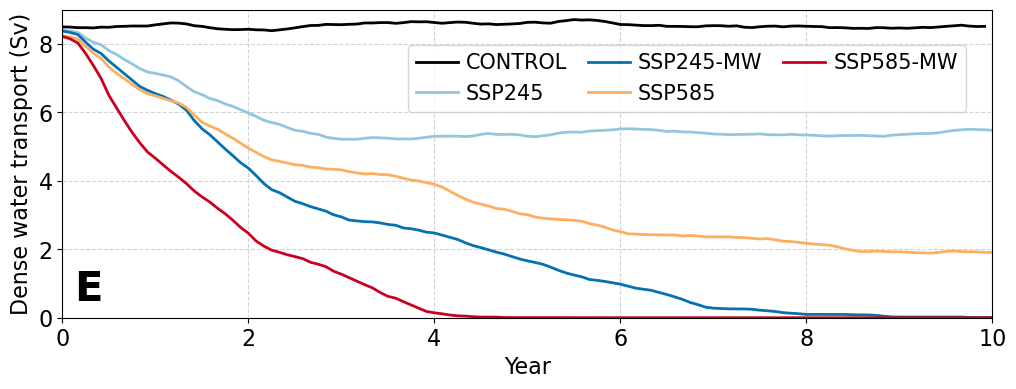

In [22]:
# define labels, colours etc. for figure
colours = ['k', '#92c5de', '#0571b0', '#fdae61', '#ca0020', ]
expt_labels = ['CONTROL', 'SSP245', 'SSP245 MW', 'SSP585', 'SSP585 MW']
expts = [control, ssp245, ssp245mw, ssp585, ssp585mw]

# create figure
plt.rcParams['font.size'] = 16
figure_1E, ax = plt.subplots(ncols = 1, figsize = (12, 4))
plt.subplots_adjust(wspace=0.25)

# DSW export timeseries 
ax.plot(np.arange(0, 120, 1), dsw_export_ctrl_ts.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), color=colours[0], lw=2, label = 'CONTROL')
ax.plot(np.arange(0, 174, 1), dsw_export_ssp245_ts.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), color=colours[1], lw=2, label = 'SSP245')
ax.plot(np.arange(0, 174, 1), dsw_export_ssp245mw_ts.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), color=colours[2], lw=2, label = 'SSP245-MW')
ax.plot(np.arange(0, 174, 1), dsw_export_ssp585_ts.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), color=colours[3], lw=2, label = 'SSP585')
ax.plot(np.arange(0, 174, 1), dsw_export_ssp585mw_ts.rolling(time = 12, center = True).mean('time').isel(time=slice(6,-6)), color=colours[4], lw=2, label = 'SSP585-MW')

# add labels 
ax.set_xlim(0,120)
ax.set_xticks(np.arange(0, 144, 24))
ax.set_xticklabels(np.arange(0, 12, 2))
ax.set_ylim([0,9])
ax.grid(linestyle = '--', color = 'lightgrey')
ax.set_xlabel('Year')
ax.set_ylabel('Dense water transport (Sv)')

ax.text(1.5, 0.5, 'E',  c='k', fontsize=30, fontweight='bold',)

# plt legend
ax.legend(ncols=3, handletextpad=0.4, columnspacing=1, bbox_to_anchor = [0.36, 0.635], fontsize=15)

# save to file
save_flag = 0
figfile = '../figs/Fig01_E.jpg'
if save_flag == 1:
    figure_1E.savefig(figfile, bbox_inches='tight', dpi=300)

plt.show()